# Отчёт по ДЗ-2

В этом нотбуке представлены результаты всех заданий.

Первые два я смог запустить из Colab/Kaggle, поэтому работал напрямую отсюда.
В третьем подключиться через ssh к Kaggle не получилось, поэтому я написал краткое руководство к коду и представил результаты в markdown.

In [1]:
!git clone https://github.com/Alexander4127/effdl_pipeline_opt.git

Cloning into 'effdl_pipeline_opt'...
remote: Enumerating objects: 153, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 153 (delta 63), reused 146 (delta 56), pack-reused 0
Receiving objects: 100% (153/153), 27.71 KiB | 3.96 MiB/s, done.
Resolving deltas: 100% (63/63), done.


In [2]:
%cd effdl_pipeline_opt

/kaggle/working/effdl_pipeline_opt


## Task1

In [4]:
%load_ext autoreload
%autoreload 2

In [11]:
%cd task1

/content/effdl_pipeline_opt/task1


#### Скачиваем данные

In [17]:
!bash download_data.sh

--2024-02-17 22:18:29--  https://www.dropbox.com/s/tc1qo73rrm3gt3m/CARVANA.zip

Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212

Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.

HTTP request sent, awaiting response... 302 Found

Location: /s/raw/tc1qo73rrm3gt3m/CARVANA.zip [following]

--2024-02-17 22:18:29--  https://www.dropbox.com/s/raw/tc1qo73rrm3gt3m/CARVANA.zip

Reusing existing connection to www.dropbox.com:443.

HTTP request sent, awaiting response... 302 Found

Location: https://uc19b8c800e301b7a9c6b86a26a6.dl.dropboxusercontent.com/cd/0/inline/CNdnsCER3rIth1VE47Ksl36OdUXAbawhyOaU1oStJTl0aV35CM7yOYQYyg6DbgWTT0Pndcic0CO1Okwr7C24Hl2NR2RqA6g35nzwmH5w24_abmzWfOESdCFuxtRqRMNet8ipSJZOMegXPNt1Ctj61cKZ/file# [following]

--2024-02-17 22:18:30--  https://uc19b8c800e301b7a9c6b86a26a6.dl.dropboxusercontent.com/cd/0/inline/CNdnsCER3rIth1VE47Ksl36OdUXAbawhyOaU1oStJTl0aV35CM7yOYQYyg6DbgWTT0Pndcic0CO1Okwr7C24Hl2NR2RqA6

In [41]:
!git pull

remote: Enumerating objects: 7, done.

remote: Counting objects: 100% (7/7), done.

remote: Compressing objects: 100% (2/2), done.

remote: Total 4 (delta 2), reused 4 (delta 2), pack-reused 0

Unpacking objects: 100% (4/4), 349 bytes | 349.00 KiB/s, done.

From https://github.com/Alexander4127/effdl_pipeline_opt

   ef51a21..ffee120  main       -> origin/main

Updating ef51a21..ffee120

Fast-forward

 task1/train.py | 2 +-

 1 file changed, 1 insertion(+), 1 deletion(-)


In [19]:
import torch

torch.cuda.empty_cache()

#### Обучение в full precision

Здесь я столкнулся с ловушкой Efficient DL.
Batch size 128 даёт ошибку CUDA OOM, поэтому его пришлось уменьшить.
После я оставил его таким же и обнаружил, что при его уменьшении модель неплохо учится в half precision без loss scaling-а. Вопреки материалу лекций, я обнаружил, что batch_size = 128 влезает в half precision, поэтому со следующего эксперимента удалось вернуться к первоначальному значению.

In [35]:
!python train.py --num_epochs=1 --batch_size=100  # full precision - 1 epoch (batch_size = 128 is too much)
# interesting fact: for half precision we won't see OOM in contradiction with lectures

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(

Loss: 0.599 Accuracy: 96.3111: 100% 51/51 [02:15<00:00,  2.66s/it]


#### Пробуем обучиться в half без вспомогательных инструментов

Здесь мы наблюдаем значительно снижение качества по сравнению с full precision.

In [36]:
!python train.py --num_epochs=1 --batch_size=128 --precision=half  # check it doesn't work with none scaling - accuracy < 92%

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(

Loss: 0.6334 Accuracy: 91.986: 100% 40/40 [02:12<00:00,  3.30s/it]


#### Используем static loss scaling

Получаем нужное качество (пусть и немного ниже full precision, но не забываем про разный batch size).

In [37]:
!python train.py --batch_size=128 --precision=half --loss_scaling=static --scale_factor=128 # static loss scaling - much better

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(

Loss: 0.6087 Accuracy: 95.0283: 100% 40/40 [02:11<00:00,  3.28s/it]

Loss: 0.5966 Accuracy: 97.7502: 100% 40/40 [02:10<00:00,  3.25s/it]

Loss: 0.587 Accuracy: 98.2706: 100% 40/40 [02:09<00:00,  3.24s/it]

Loss: 0.5846 Accuracy: 98.6754: 100% 40/40 [02:10<00:00,  3.25s/it]

Loss: 0.5866 Accuracy: 98.8362: 100% 40/40 [02:09<00:00,  3.25s/it]


#### Используем dynamic loss scaling

Поскольку количество шагов за эпоху небольшое, начальное значение scale_factor не успевает поменяться. Я установил значение в 2000 шагов без нанов, чтобы его увеличить в соответствии с [гайдом](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html#scalefactor). Поэтому для валидации проведём ещё один эксперимент.

In [39]:
!python train.py --batch_size=128 --precision=half --loss_scaling=dynamic --scale_factor=128 # dynamic loss scaling - the same

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(

Loss: 0.6055 Accuracy: 95.0334: 100% 40/40 [02:11<00:00,  3.28s/it]

Loss: 0.5927 Accuracy: 97.6989: 100% 40/40 [02:08<00:00,  3.21s/it]

Loss: 0.589 Accuracy: 98.5548: 100% 40/40 [02:11<00:00,  3.28s/it]

Loss: 0.5826 Accuracy: 98.709: 100% 40/40 [02:10<00:00,  3.25s/it]

Loss: 0.5805 Accuracy: 98.5847: 100% 40/40 [02:09<00:00,  3.23s/it]


#### Проверяем работу dynamic loss scaling

Для этого я взял начальный scale_factor слишком большим, однако мы видим, что он достаточно быстро уменьшается до значений, при которых модель хорошо учится. Также интересно, что со сходимостью к оптимуму подходящее значение scale_factor становится выше (логично предположить, что уменьшается норма градиента).

In [42]:
!python train.py --batch_size=128 --precision=half --loss_scaling=dynamic --scale_factor=10000000 # check for large initial scale_factor - is OK

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.

  warnings.warn(_create_warning_msg(

  0% 0/40 [00:00<?, ?it/s]WARNING:root:Faced grad overflow with factor = 10000000.0

Loss: 0.7935 Accuracy: 72.3624:   2% 1/40 [00:16<10:59, 16.91s/it]WARNING:root:Faced grad overflow with factor = 5000000.0

Loss: 0.7862 Accuracy: 72.4633:   5% 2/40 [00:17<04:34,  7.24s/it]WARNING:root:Faced grad overflow with factor = 2500000.0

Loss: 0.7962 Accuracy: 72.2103:   8% 3/40 [00:17<02:33,  4.14s/it]WARNING:root:Faced grad overflow with factor = 1250000.0

Loss: 0.7887 Accuracy: 72.2932:  10% 4/40 [00:18<01:36,  2.69s/it]

## Task 2

In [4]:
%cd task2

/kaggle/working/effdl_pipeline_opt/task2


#### Для корректного скачивания данных может потребоваться конкретная версия datasets

In [6]:
# !pip install datasets==2.17.0

In [7]:
!python download_data.py

/opt/conda/lib/python3.10/site-packages/datasets/load.py:2516: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(
Generating test split: 100%|█████| 4358/4358 [00:00<00:00, 353650.44 examples/s]
Generating train split: 100%|█| 1801350/1801350 [00:02<00:00, 807389.74 examples
Generating validation split: 100%|█| 3760/3760 [00:00<00:00, 619231.31 examples/
Saving the dataset (2/2 shards): 100%|█| 1801350/1801350 [00:01<00:00, 1723212.4


In [17]:
!git pull

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 1), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (4/4), 437 bytes | 437.00 KiB/s, done.
From https://github.com/Alexander4127/effdl_pipeline_opt
   17d4e99..5ca8de1  main       -> origin/main
Updating 17d4e99..5ca8de1
Fast-forward
 task2/dataset.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


#### Прогон на данных

Остановимся подробнее на имплементации

- `dataset.py`
    1. `SimpleDataset` является базовой имплементацией датасета, которая включает инициализацию токенайзера и словаря. Дополнительно все тексты переводятся в индексы токенов уже при инициализации для ускорения `__getitem__`. В процессе оказалось, что эпоха на всех данных для наивной имплементации идёт больше полутора часов. Поскольку автор пользовался Kaggle, было принято решение уменьшить набор данных в несколько раз с помощью взятия хэша от строчки.
    2. `BrainDataset` и `BigBrainDataset` отличаются только параметрами `collate_fn`.
    3. `BatchSampler` после группировки текстов по длине затем ещё раз группирует их по бакетам длин. Так в `self.length_mapper[len]` будут лежать элементы с длинами `len <= length <= len + k`. Асимптотика построения такого датасета `O(nk)`, считая максимальную длину последовательности константой.
- `run_epoch.py`
    1. `get_model` использует классы `nn.Embedding`, `PositionalEncoding`, `nn.TransformerDecoderLayer` и предложенные размерности. В качестве `num_embeddings` передаём размер словаря.
    2. `run_epoch` принимает параметры для данных и `warmup_steps` - количество шагов, которые пропускаются для "прогрева" GPU.
    3. `__main__` запускает все предложенные эксперименты и сохраняет результаты в виде `.csv`. Дополнительно к перечисленным в условии логируются
        - `Init`: время, потраченное на инициализацию датасета и модели до начала обучения.
        - `SeqLen`: средняя длина последовательности токенов.
        - `SeqDiff`: средняя разность между максимальной и минимальной длиной последовательности в батче.
- `download_data.py` содержит рабочую имплементацию скачивания данных.

In [12]:
# take part of data
!python run_epoch.py --batch_size=32

BRAIN-None: 100%|███████████████████████████| 1246/1246 [02:19<00:00,  8.90it/s]
Brain: [0.1478743553161621, 0.0500032901763916, 0.10864496231079102, 0.10589329778713032, 0.10598361492156982, 86.76889560508752, 293.5264598540146]
BIG_BRAIN-None: 100%|███████████████████████| 1246/1246 [01:03<00:00, 19.57it/s]
Big Brain: [0.12201714515686035, 0.012788057327270508, 0.10492634773254395, 0.04524815996197888, 0.04276764392852783, 86.8201737816396, 294.9844890510949]
/opt/conda/lib/python3.10/site-packages/torch/utils/data/sampler.py:64: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn("`data_source` argument is not used and will be removed in 2.2.0."
ULTRA_DUPER_BIG_BRAIN-1: 100%|████████████████| 473/473 [00:11<00:00, 40.77it/s]
Ultra Big Brain. k = 1: [3.862823724746704, 0.0019099712371826172, 0.04419255256652832, 0.018506721077319637, 0.016651153564453125, 174.05069648441201, 0.92879256

In [13]:
import pandas as pd
pd.read_csv("result.csv")

,Unnamed: 0,Init,Min,Max,Mean,Med,SeqLen,SeqDiff
0,Brain,0.147874,0.050003,0.108645,0.105893,0.105984,86.768896,293.526460
1,Big Brain,0.122017,0.012788,0.104926,0.045248,0.042768,86.820174,294.984489
2,Ultra Big Brain. k = 1,3.862824,0.001910,0.044193,0.018507,0.016651,174.050696,0.928793
3,Ultra Big Brain. k = 5,0.171529,0.002362,0.052524,0.025678,0.025449,200.545254,4.715170
4,Ultra Big Brain. k = 10,0.245162,0.002409,0.063700,0.028274,0.026082,215.480230,9.541796
5,Ultra Big Brain. k = 20,0.477346,0.003859,0.066811,0.032887,0.031215,227.563532,19.235294
6,Ultra Big Brain. k = 50,1.800483,0.004863,0.079155,0.040526,0.040478,252.005470,46.925697
7,Ultra Big Brain. k = 640,43.865783,0.011000,0.107440,0.071930,0.069262,299.803569,233.160991


#### Выводы

Для удобства будем называть типы `B` (`Brain`), `BB` (`Big Brain`), `UB` (`Ultra Big Brain`).

- Время инициализации
    1. Для `B, BB` и `UB` с небольшими `k` оно небольшое и близко (`k = 1` исключение, поскольку нужно потратить время на группировку по длинам, которая потом кэшируется).
    2. С ростом `k` для `UB` мы наблюдаем достаточно сильное замедление, однако это не проблема, поскольку такой подход должен использоваться для малых `k`.
- Распределение времени работы
    1. При сравнении `B` и `BB` мы видим ускорение в 2 раза в среднем и в 4 в лучшем случае. Худший случай ожидаемо совпадает, поскольку последовательность длины 640 скорее всего найдётся.
    2. При переходе от `BB` к `UB` также заметно значительное ускорение, которое постепенно теряется при увеличении `k`, что особенно заметно на экстремальных статистиках. Однако статистики для `BB` и `UB.k=640` не совпадают, второе работает в среднем несколько медленнее.
- Распределение длин последовательностей
    1. Для первого и второго метода они совпадают, что вполне ожидаемо - мы рассматриваем их до паддинга.
    2. Для `BB` и `UB.k=640` статистики отличаются, поскольку во втором случае мы начинаем с равномерного семплирования длины, что неверно при желании просемплировать все последовательности равновероятно. Это объясняет разницу и во времени работы. Чтобы добиться приблизительно одинаковых значений, нужно проставлять веса как при семплировании бакета (длины).

In [14]:
# pd.read_csv("result.csv").to_latex("result.tex")

## Task 3

#### Краткое руководство для использования

In [ ]:
%cd task3

### Loading data
!pip install kaggle
!mkdir .kaggle
!echo '{"username":"<your kaggle name>","key":"<your kaggle token>"}' > .kaggle/kaggle.json

!bash download_data.sh

### Running code
!python run_epoch.py

### Первая часть (на CPU)

*Все измерения я взял из tensorboard -> trace*

- Forward pass (total 945ms)
    1. Embedding ~ 156ms (если имелся в виду positional encoding патчей)
    2. Self-Attention ~ 92ms x 12 (по количеству таких слоёв)
    3. Feed-Forward ~ 49ms x 12 (по количеству таких слоёв)
    4. GeLU ~ 1.5ms
    5. SoftMax ~ 0.4ms
- Backward pass (total 1,435 ms) - в полтора раза дольше.
- Several training iterations ~ 20 sec per iter

### Dataloader

При первом же запуске `tensorboard_trace_handler` мы обнаруживаем, что большая часть времени приходится на загрузку данных, то есть с практической точки зрения можно вообще не оптимизировать код модели, поскольку выиграть больше 10% будет невозможно. Поэтому в первую очередь мы попытаемся ускорить именно эту часть.

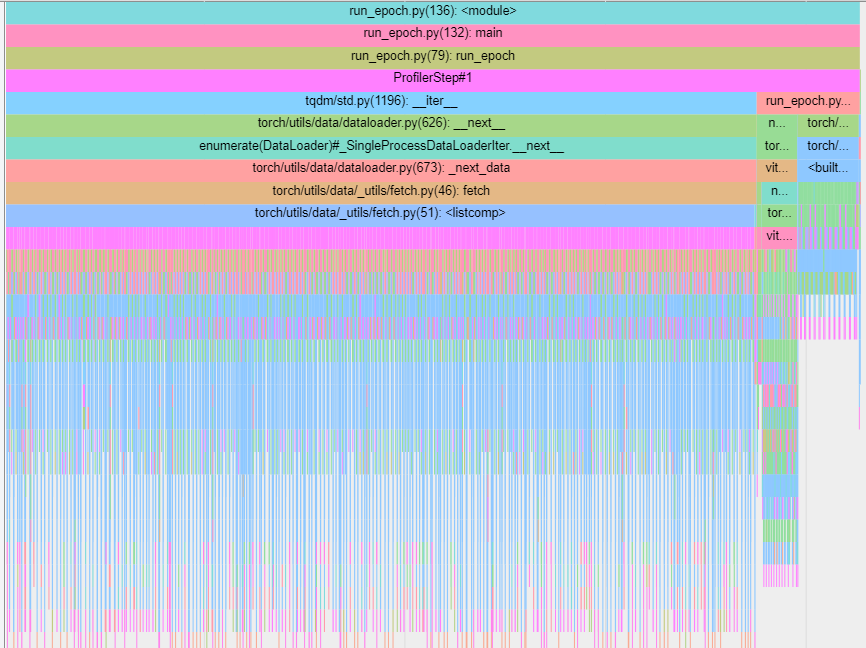

In [8]:
from PIL import Image

Image.open("pic/dataloader.png").convert("RGB")

Вспомогательной идеей в данном случае будет рассмотрение графика потребления CPU. Мы можем видеть, что оно используется не оптимально, скорее всего большую часть времени просто ожидая, поэтому следующий шаг интуитивно понятен.

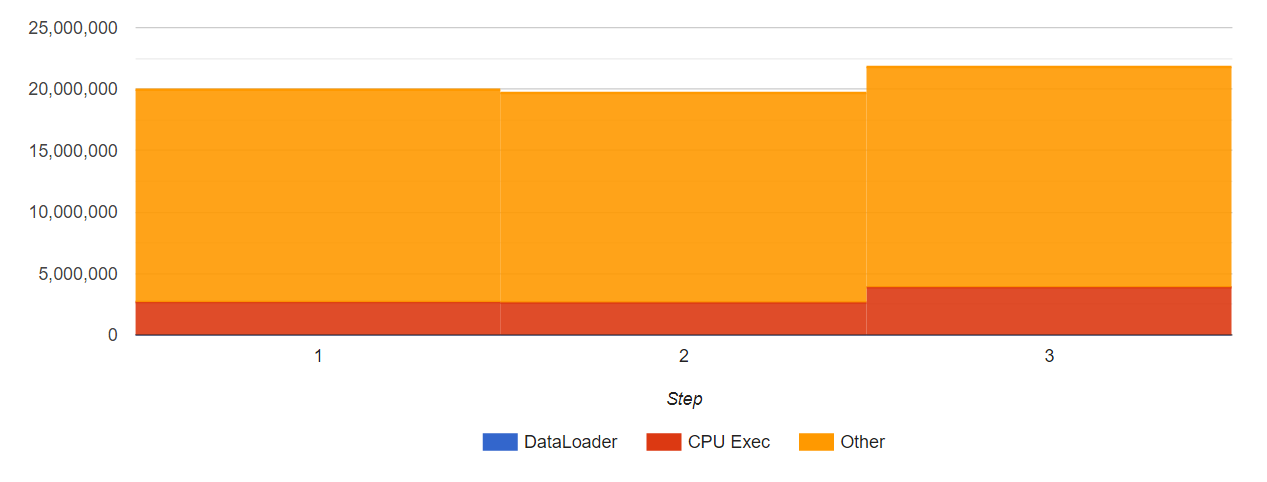

In [10]:
Image.open("pic/dataloader_dist.png").convert("RGB")

#### Number of workers

Первая же идея - распараллелить процесс с использованием `num_workers > 0`.

Результат: для `num_workers = 5` мы ускорили обучение в несколько раз и добились полноценного потребления CPU.

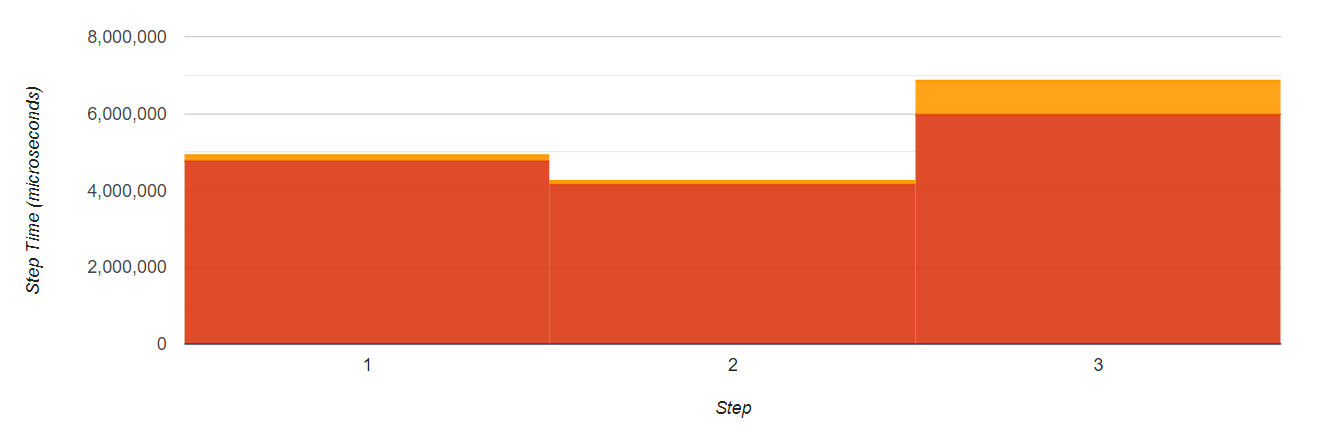

In [9]:
Image.open("pic/dataloader_nwork.png").convert("RGB")

#### Pin memory

Другой стандартный способ ускорить загрузку данных -- `pin_memory`.
Попробуем сделать время ожидания для процессора ещё меньше.

Результат: время ожидания стало ещё меньше. Выброс на последнем шаге стал больше, однако вряд ли это вызвано применением `pin_memory`, поэтому данное улучшение тоже помогает.

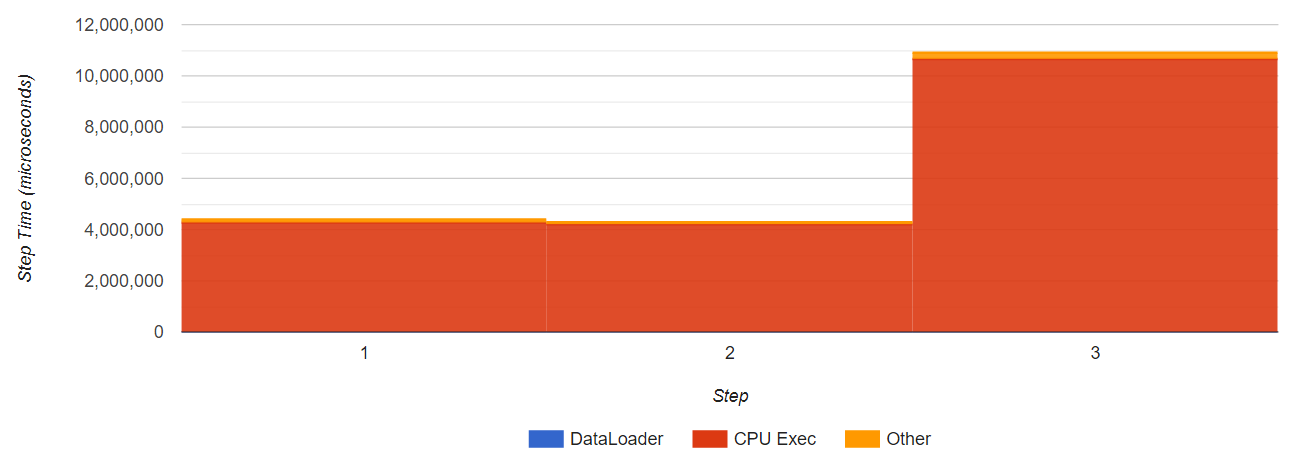

In [11]:
Image.open("pic/dataloader_pin.png").convert("RGB")

### Метод `__getitem__`

Мы исправили проблемы в использовании класса `Dataloader`, теперь более подробно рассмотрим метод `__getitem__`.

#### Использование PIL.Image

Достаточно большую часть времени работы `__getitem__` занимает чтение картинки этим методом.
На лекции мы обсуждали, что такой способ загрузки с жёсткого диска может быть не самым оптимальным.
В качестве эксперимента попробуем использовать `torchvision.io.read_image`, который должен работать быстрее.

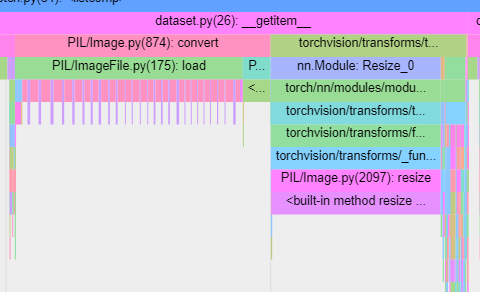

In [16]:
Image.open("pic/pil.png").convert("RGB")

Результат: ускорения не получилось, вероятно, дело в небольшом размере картинок и других bottleneck-ах.

#### Лишний Crop

При изучении применяемых аугментаций, мы обнаруживаем два применения `Crop` подряд.
Нам нужно оставить только первый из них, поскольку это обучающая выборка.

Результат: мы точно ускорили код, однако изменения очень малы.

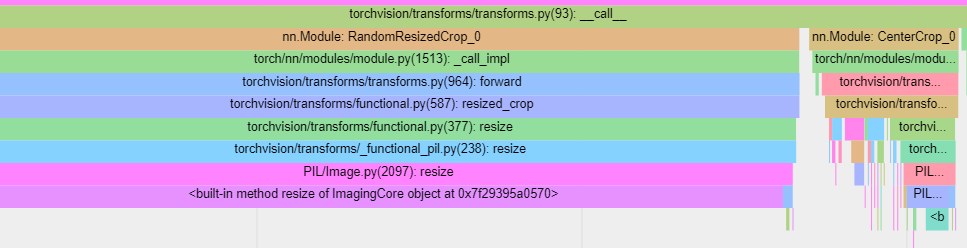

In [12]:
Image.open("pic/dataloader_crop.png").convert("RGB")

### Изменения внутри модели

#### Identity и Dropout

После загрузки данных можно перейти к самой модели.
Сначала избавимся от явно лишних методов, которые впустую используют ресурсы, заглянем в раздел Module.
Мы видим применение `Identity` и `Dropout`, можно обратить внимание, что коэффициент в любом `Dropout` будет 0, поэтому их смело можно убрать.

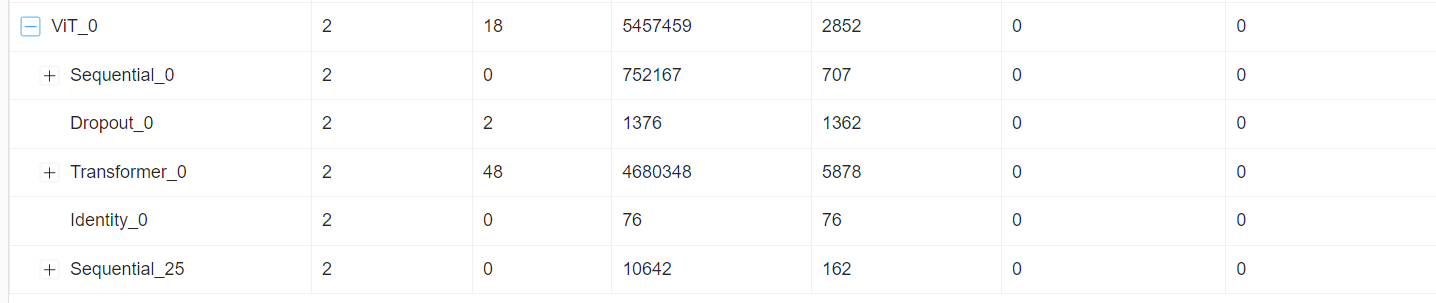

In [13]:
Image.open("pic/module.png").convert("RGB")

`Dropout` применяется во многих слоях, поэтому наиболее удобно добавить везде проверку, что его коэффициент положительный, а если это не так, то не использовать его. `nn.Identity` же можно просто убрать.

Результат: изменение во времени работы мало, хоть и позитивно, но мы значительно упростили архитектуру, убрав ненужные слои, повысив читаемость.

#### Repeat

В коде используется некоторая библиотека `einops`, некоторые функции из которой можно заметить станартными из `torch`, что мы и сделаем с функцией `repeat`.

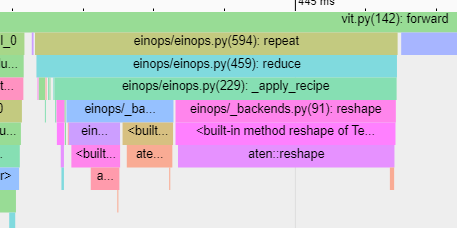

In [14]:
Image.open("pic/repeat.png").convert("RGB")

Результат: время работы функции осталось таким же, однако упростилась структура.

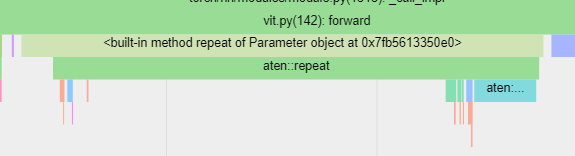

In [15]:
Image.open("pic/torch_repeat.png").convert("RGB")

### Внешние функции

Оставшиеся изменения уже можно сделать не исходя из профайлера, а скорее из-за работы с высокоуровневым кодом, они посвящены файлу `run_epoch.py` и заключаются в следующем.

1. Добавление `torch.inference_mode` к эпохе валидации, чтобы не считать градиенты.
2. Замена `(output.argmax(dim=1) == label).float().mean()` на более ёмкое `torch.mean(output.argmax(dim=1) == label, dtype=torch.float32)` для подсчёта accuracy.